## Setup

In [3]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [4]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [5]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [6]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [7]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


In [8]:
%%R 
# passes the CENSUS_API_KEY environment variable we loaded
# in Python above to R (specifically to the tidycensus package)
census_api_key(Sys.getenv("CENSUS_API_KEY"))

install = TRUE

To install your API key for use in future sessions, run this function with `install = TRUE`.


In [9]:

%%R

# Retrieve ACS data for New York City census tracts
nyc_census_data <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    # population = "B01002_001",
    # total_units = "B25001_001",
    median_age = "B01002_001"  # Median age of the total population
  ),
  year = 2021,
  survey = "acs5",
  geometry = TRUE
)

# Display the retrieved data
nyc_census_data

Simple feature collection with 2327 features and 5 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME   variable estimate
1  36081014700   Census Tract 147, Queens County, New York median_age     38.2
2  36047058400    Census Tract 584, Kings County, New York median_age     42.2
3  36061006900  Census Tract 69, New York County, New York median_age     36.6
4  36047073000    Census Tract 730, Kings County, New York median_age     41.2
5  36047100400   Census Tract 1004, Kings County, New York median_age     37.2
6  36047055700    Census Tract 557, Kings County, New York median_age     32.5
7  36005022101 Census Tract 221.01, Bronx County, New York median_age     30.6
8  36081047000   Census Tract 470, Queens County, New York median_age     41.7
9  36047050402 Census Tract 504.02, Kings Cou

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


#### 

In [10]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 4 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 5
   GEOID      NAME                   geometry median_age_estimate median_age_moe
   <chr>      <chr>        <MULTIPOLYGON [°]>               <dbl>          <dbl>
 1 360810147… Cens… (((-73.9137 40.76548, -7…                38.2            6  
 2 360470584… Cens… (((-73.96103 40.59616, -…                42.2            3.3
 3 360610069… Cens… (((-74.02064 40.73039, -…                36.6            3.1
 4 360470730… Cens… (((-73.93345 40.6257, -7…                41.2           11.2
 5 360471004… Cens… (((-73.90735 40.63083, -…                37.2            6.5
 6 360470557… Cens… (((-73.96279 40.72256, -…                32.5            1.6
 7 360050221… Cens… (((-73.92012 40.83759, -…                30.6            3.7
 8 360810470… Cens… (((-

In [11]:
%%R -w 1000
colnames(nyc_census_data)

[1] "GEOID"               "NAME"                "geometry"           
[4] "median_age_estimate" "median_age_moe"     


In [12]:
%%R 

# Extract borough name from NAME by splitting strings like "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    ) 

nyc_census_data

Simple feature collection with 2327 features and 5 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 6
   GEOID      NAME                   geometry median_age_estimate median_age_moe
 * <chr>      <chr>        <MULTIPOLYGON [°]>               <dbl>          <dbl>
 1 360810147… Cens… (((-73.9137 40.76548, -7…                38.2            6  
 2 360470584… Cens… (((-73.96103 40.59616, -…                42.2            3.3
 3 360610069… Cens… (((-74.02064 40.73039, -…                36.6            3.1
 4 360470730… Cens… (((-73.93345 40.6257, -7…                41.2           11.2
 5 360471004… Cens… (((-73.90735 40.63083, -…                37.2            6.5
 6 360470557… Cens… (((-73.96279 40.72256, -…                32.5            1.6
 7 360050221… Cens… (((-73.92012 40.83759, -…                30.6            3.7
 8 360810470… Cens… (((-

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 91 rows containing non-finite outside the scale range (`stat_bin()`). 



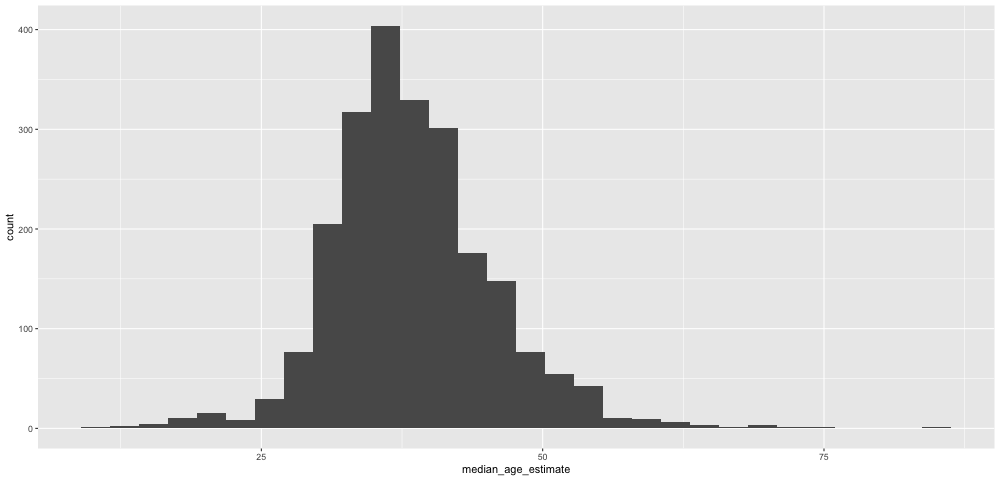

In [13]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=median_age_estimate) +
    geom_histogram()

### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [14]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

nyc_census_data

Error in `tidyr::pivot_wider()`:
! Can't select columns that don't exist.
✖ Column `variable` doesn't exist.
Run `rlang::last_trace()` to see where the error occurred.

Error in tidyr::pivot_wider(data = data, ..., id_cols = { :


RInterpreterError: Failed to parse and evaluate line '\nnyc_census_data <- nyc_census_data %>% \n  pivot_wider(\n    names_from=variable, \n    values_from = c(estimate, moe),\n    names_glue = "{variable}_{.value}"\n  )# pivot from wide to long\n\nnyc_census_data\n'.
R error message: 'Error in tidyr::pivot_wider(data = data, ..., id_cols = { :'

### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [15]:
%%R

colnames(nyc_census_data)

[1] "GEOID"               "NAME"                "geometry"           
[4] "median_age_estimate" "median_age_moe"      "borough"            


In [16]:
%%R

nyc_census_data <- nyc_census_data %>% pivot_wider( names_from=variable, values_from = c(estimate, moe), names_glue = "{variable}{.value}" )# pivot from wide to long_

nyc_census_data

Error in `tidyr::pivot_wider()`:
! Can't select columns that don't exist.
✖ Column `variable` doesn't exist.
Run `rlang::last_trace()` to see where the error occurred.

Error in tidyr::pivot_wider(data = data, ..., id_cols = { :


RInterpreterError: Failed to parse and evaluate line '\nnyc_census_data <- nyc_census_data %>% pivot_wider( names_from=variable, values_from = c(estimate, moe), names_glue = "{variable}{.value}" )# pivot from wide to long_\n\nnyc_census_data\n'.
R error message: 'Error in tidyr::pivot_wider(data = data, ..., id_cols = { :'

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 91 rows containing non-finite outside the scale range (`stat_bin()`). 



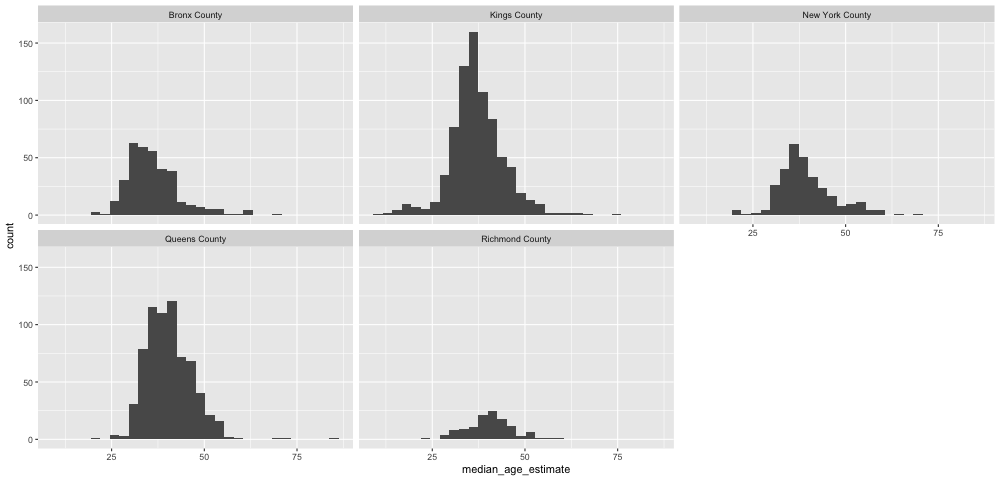

In [17]:

%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=median_age_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 


### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 91 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 91 rows containing missing values or values outside the scale range
(`geom_point()`). 



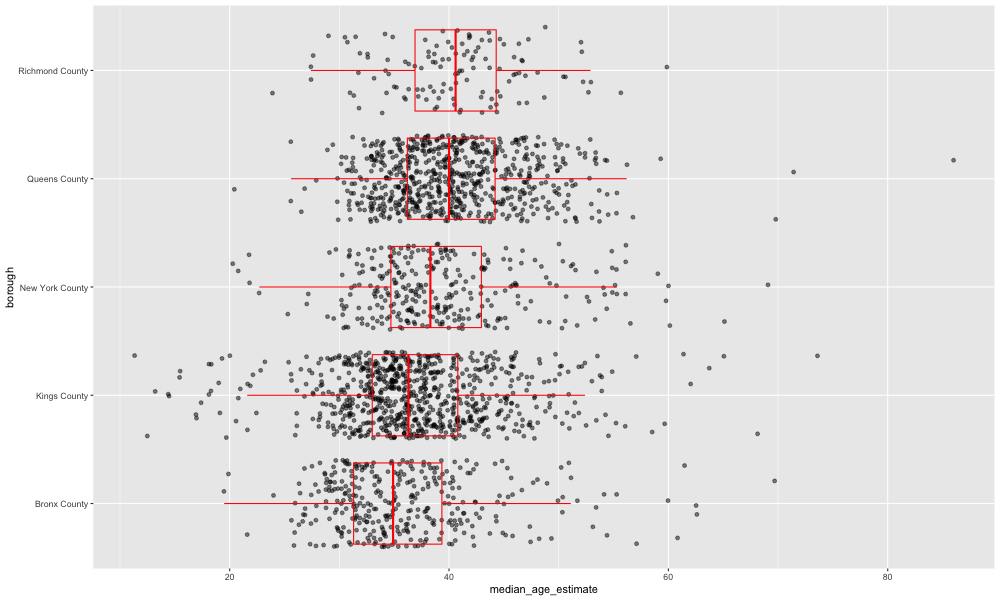

In [18]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=median_age_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 
# your code here. refer to example notebooks for help


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

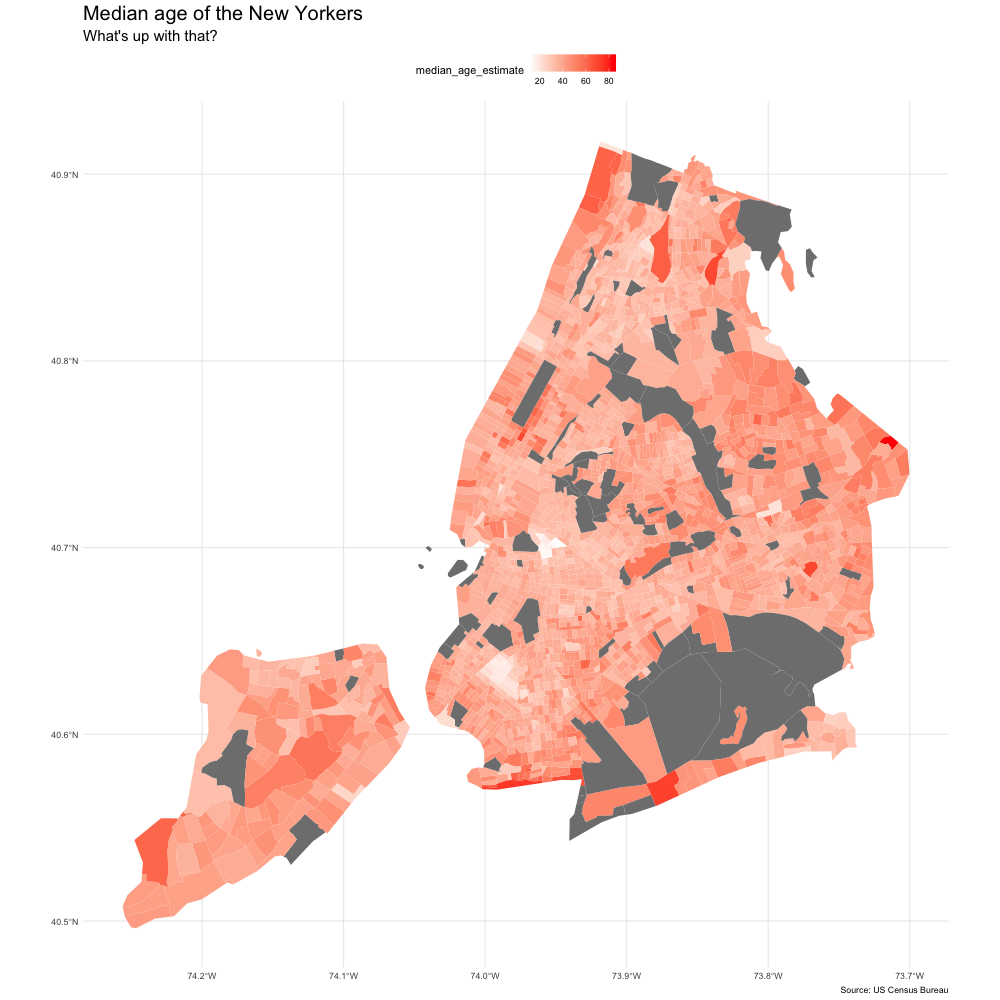

In [19]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = median_age_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "Median age of the New Yorkers",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )

In [20]:
%%R

install.packages("osmdata")

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Marseille) 

Selection:  64



The downloaded binary packages are in
	/var/folders/fd/2_6_clt56hg9lxglbp6447680000gn/T//RtmpE5Yd9e/downloaded_packages


trying URL 'https://mirror.las.iastate.edu/CRAN/bin/macosx/big-sur-arm64/contrib/4.4/osmdata_0.2.5.tgz'
Content type 'application/x-gzip' length 4083990 bytes (3.9 MB)
downloaded 3.9 MB

In addition: Warning message:
In doTryCatch(return(expr), name, parentenv, handler) :
  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <34C5A480-1AC4-30DF-83C9-30A913FC042E> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: tried: '/opt/X11/lib/libSM.6.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/X11/lib/libSM.6.dylib' (no such file), '/opt/X11/lib/libSM.6.dylib' (no such file), '/usr/local/lib/libSM.6.dylib' (no such file), '/usr/lib/libSM.6.dylib' (no such file, not in dyld cache)


Retrieving data for the year 2022
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '36' for state 'NY'
Using FIPS code '047' for 'Kings County'
Using FIPS code '36' for state 'NY'
Using FIPS code '081' for 'Queens County'
Using FIPS code '36' for state 'NY'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '36' for state 'NY'
Using FIPS code '085' for 'Richmond County'


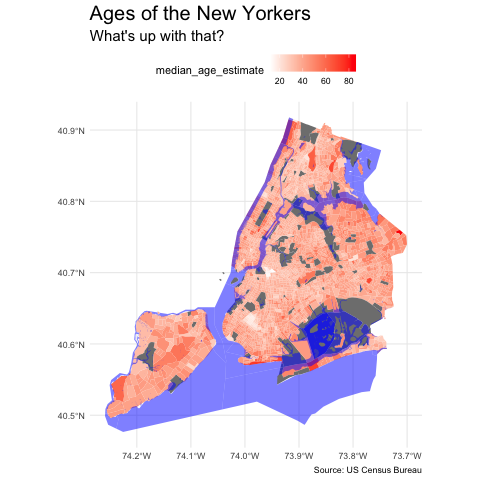

In [24]:
%%R

library(ggplot2)
library(sf)
library(tigris)
library(dplyr)

# Get NYC water areas from Census TIGER/Line
nyc_water <- area_water(state = "NY", county = c("New York", "Kings", "Queens", "Bronx", "Richmond"), class = "sf")

# Plot map with water areas
nyc_census_data %>%
  ggplot() +
  geom_sf(aes(fill = median_age_estimate), color = NA) +  # Census tract map
  geom_sf(data = nyc_water, fill = "blue", color = NA, alpha = 0.5) +  # Water areas overlay
  scale_fill_gradient(low = "white", high = "red") +
  theme_minimal() +
  labs(
    title = "Ages of the New Yorkers",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    legend.position = "top"
  )